In [ ]:
!unzip /content/drive/MyDrive/Training/training200_2_rotations_only.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/training200_2_rotations_only/6_1_1_20170103223434927_tilted_30.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170103223434927_tilted_-30.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170109192734062_original.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170109192734062_tilted_30.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170109192734062_tilted_-30.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170109193902904_original.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170109193902904_tilted_30.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170109193902904_tilted_-30.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170112205056443_original.png  
  inflating: /content/training200_2_rotations_only/6_1_1_20170112205056443_tilted_30.png  
  inflating: /content/training200_2_rot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training the model

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.layers import BatchNormalization

BASE_DIR = '/content/training200_2_rotations_only'

# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    race = int(temp[2])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)

df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels
df.head()

# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

# map labels for race
race_dict = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

  0%|          | 0/20724 [00:00<?, ?it/s]

Plotting of age distribution in our dataset

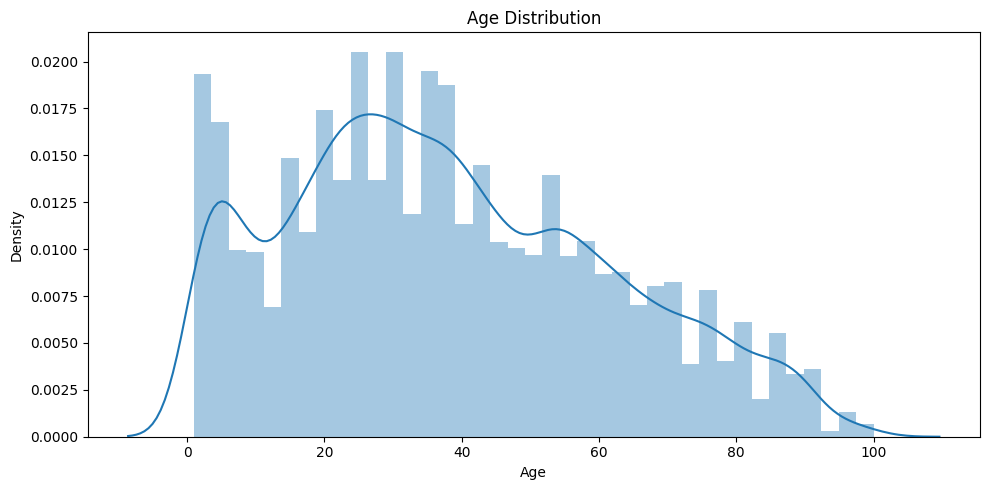

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(df['age'])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Extract features and normalize the image

In [ ]:
from PIL import Image
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(df['image'])
X = X/255.0

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

  0%|          | 0/20724 [00:00<?, ?it/s]

Split the data into training and testing sets for gender and age labels

In [ ]:
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42
)

In [ ]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

In building our age prediction model, we designed a Convolutional Neural Network with five convolutional layers followed by batch normalization and max-pooling. The flattened output enters a dense layer with 256 units, incorporating non-linearity. To prevent overfitting, a dropout layer is applied. The final layer uses ReLU activation for age prediction.

In [ ]:
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
conv_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
conv_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
conv_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
conv_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu') (maxp_4)
conv_5 = BatchNormalization()(conv_5)
maxp_5 = MaxPooling2D(pool_size=(2, 2)) (conv_5)

flatten = Flatten() (maxp_5)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)

# Output layer for age prediction
output_age = Dense(1, activation='relu', name='age_out')(dropout_1)

# Model definition
model = Model(inputs=[inputs], outputs=[output_age])

model.compile(loss='mae', optimizer='adam', metrics=['mae'])


The model was then trained over 30 epochs, with a batch size of 32.

In [ ]:
# Train model
history = model.fit(x=X_train, y=y_age_train, batch_size=32, epochs=30, validation_split=0.2)

# Save the model
model.save("150_2_rotation_model.h5")

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_age_test)
print(f'Test Loss: {test_loss[0]}, Test MAE: {test_loss[1]}')

Epoch 1/30
486/486 [==============================] - 25s 30ms/step - loss: 14.0792 - mae: 14.0792 - val_loss: 14.9145 - val_mae: 14.9145
Epoch 2/30
486/486 [==============================] - 13s 27ms/step - loss: 11.0622 - mae: 11.0622 - val_loss: 12.3065 - val_mae: 12.3065
Epoch 3/30
486/486 [==============================] - 13s 27ms/step - loss: 9.9361 - mae: 9.9361 - val_loss: 26.0327 - val_mae: 26.0327
Epoch 4/30
486/486 [==============================] - 13s 28ms/step - loss: 8.9534 - mae: 8.9534 - val_loss: 14.4012 - val_mae: 14.4012
Epoch 5/30
486/486 [==============================] - 13s 27ms/step - loss: 8.4271 - mae: 8.4271 - val_loss: 9.6201 - val_mae: 9.6201
Epoch 6/30
486/486 [==============================] - 13s 27ms/step - loss: 7.9426 - mae: 7.9426 - val_loss: 15.8643 - val_mae: 15.8643
Epoch 7/30
486/486 [==============================] - 13s 27ms/step - loss: 7.3803 - mae: 7.3803 - val_loss: 8.8339 - val_mae: 8.8339
Epoch 8/30
486/486 [============================

# Model Quality Evaluation

Plotting of the model loss graph

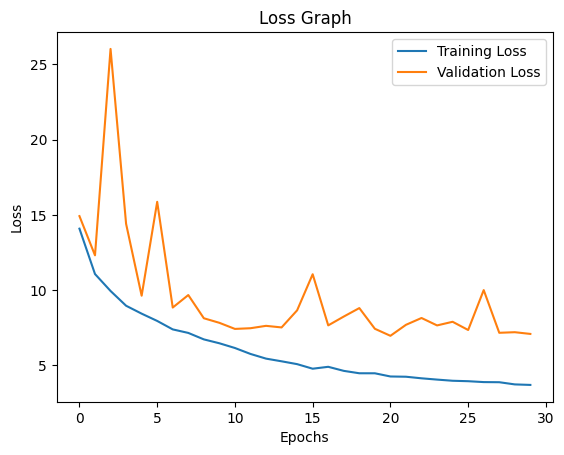

In [ ]:
# Loss Graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Visualizing the Mean Absolute Error (MAE) values for age prediction during the training of the neural network

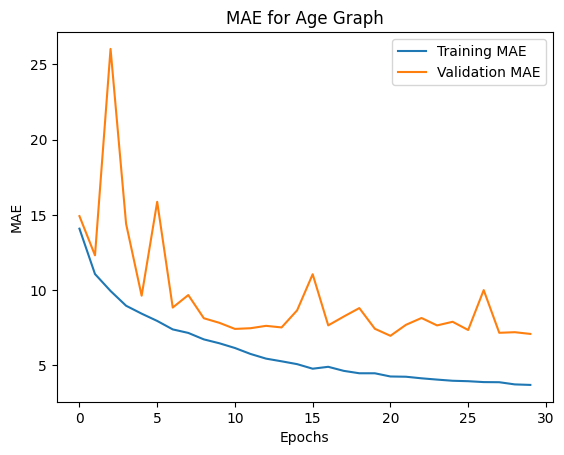

In [ ]:
# MAE (Mean Absolute Error) for Age
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE for Age Graph')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

We then examined key metrics for both training and validation phases of our model. The final training metrics and mean training metrics to indicate the convergence of the model during training.

In [ ]:
# Additional quality evaluation checks
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]
final_training_mae = history.history['mae'][-1]
final_validation_mae = history.history['val_mae'][-1]

# Calculate the mean of the metrics
mean_training_loss = np.mean(history.history['loss'])
mean_validation_loss = np.mean(history.history['val_loss'])
mean_training_mae = np.mean(history.history['mae'])
mean_validation_mae = np.mean(history.history['val_mae'])

# Print the results
print("Final Training Loss:", final_training_loss)
print("Mean Training Loss:", mean_training_loss)

print("Final Validation Loss:", final_validation_loss)
print("Mean Validation Loss:", mean_validation_loss)

print("Final Training MAE:", final_training_mae)
print("Mean Training MAE:", mean_training_mae)

print("Final Validation MAE:", final_validation_mae)
print("Mean Validation MAE:", mean_validation_mae)


Final Training Loss: 3.6876885890960693
Mean Training Loss: 5.955492854118347
Final Validation Loss: 7.079597473144531
Mean Validation Loss: 9.548196585973104
Final Training MAE: 3.6876885890960693
Mean Training MAE: 5.955492854118347
Final Validation MAE: 7.079597473144531
Mean Validation MAE: 9.548196585973104


Since it is a regression model, we then computed Mean Absolute Error (MAE) on the test set to quantify the average absolute difference between the true and predicted ages regression line, providing a measure of the model's accuracy in age estimation.

130/130 [==============================] - 4s 10ms/step
Final Test Age MAE: 3.7423401688781666


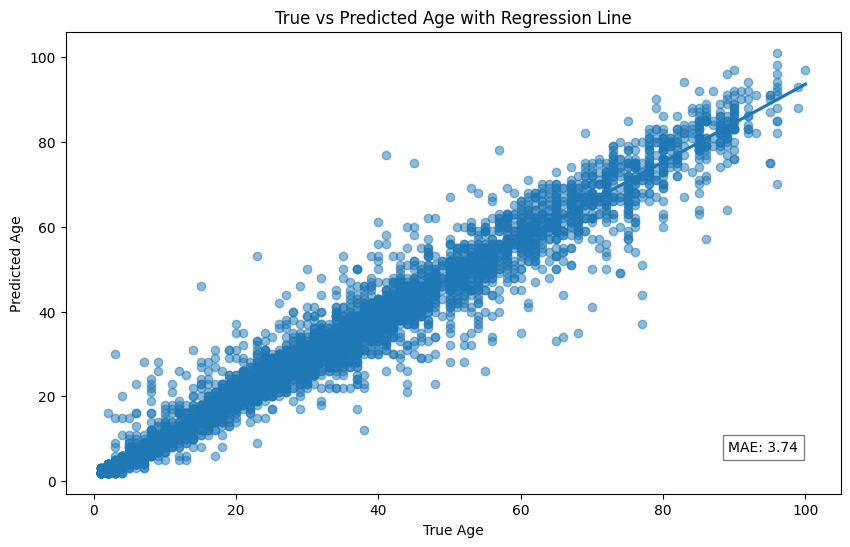

In [ ]:
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
model = load_model("/content/model_v8 (1).h5")
# Evaluate the model on the test set
predictions = model.predict(X_test)

predicted_age_int = np.round(predictions).astype(int)

# Age MAE
age_mae = mean_absolute_error(y_age_test, predicted_age_int)
print(f'Final Test Age MAE: {age_mae}')

# Plot true vs predicted age with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_age_test, y=predicted_age_int, scatter_kws={'alpha':0.5})
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('True vs Predicted Age with Regression Line')

plt.text(0.9, 0.1, f'MAE: {age_mae:.2f}', ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Even though it is a regression model, we tried to categorize the ages into ifferent groups, each spanning a range of 10 years. The actual age groups from the test set were similarly categorized for comparison. The resulting confusion matrix visually represents the model's performance in predicting age groups.

130/130 [==============================] - 1s 9ms/step


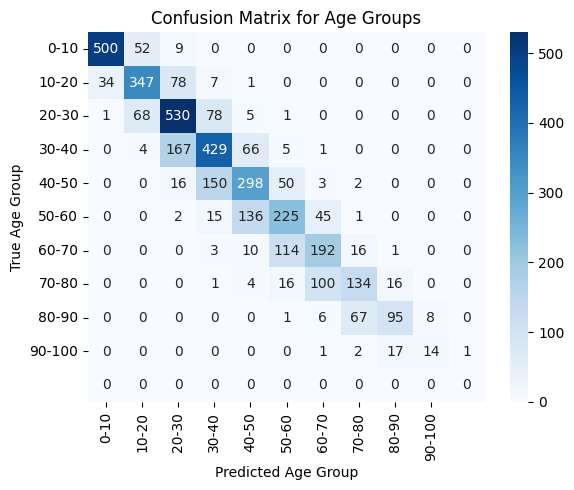

In [ ]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model
# Bin the ages into categories (you can customize the bins)
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = [f"{start}-{end}" for start, end in zip(age_bins[:-1], age_bins[1:])]
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Load the trained model
loaded_model = load_model("/content/model_v8 (1).h5")

# Make predictions on the test set
predictions = loaded_model.predict(X_test)

predicted_age_int = np.round(predictions).astype(int)

actual_age_groups = pd.cut(y_age_test, bins=age_bins, labels=age_labels, include_lowest=True).astype(str)

predicted_age_bins = pd.cut(predicted_age_int.flatten(), bins=age_bins, labels=age_labels, include_lowest=True).astype(str)

# Create a confusion matrix for age groups using the actual test set
age_conf_matrix = confusion_matrix(actual_age_groups, predicted_age_bins)

sns.heatmap(age_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=age_labels, yticklabels=age_labels)
plt.title('Confusion Matrix for Age Groups')
plt.xlabel('Predicted Age Group')
plt.ylabel('True Age Group')
plt.show()


# Case Study 1: Age Prediction Model Evaluation Across Different Races

### 1. Introduction
In the field of machine learning, the evaluation of models on diverse demographic groups is crucial to ensure fairness and unbiased performance. This case study explores the evaluation of an age prediction model across different racial categories. The objective is to assess the model's accuracy in predicting ages for individuals from distinct racial backgrounds.

### 2. Problem Statement
The goal of this case study is to understand how well a pre-trained age prediction model generalizes across racial groups. We aim to investigate if the model exhibits consistent accuracy in predicting ages for individuals belonging to different races. The study also aims to identify any potential biases or disparities in the model's predictions.

### 3. Data Description
3.1 Dataset
The dataset used in this study contains images labeled with age, gender, and race. The races are categorized into White, Black, Asian, Indian, and Others.

3.2 Model
The age prediction model is a convolutional neural network (CNN) trained to predict ages from facial images. The model architecture includes convolutional layers, max-pooling layers, and fully connected layers.

### 4. Methodology
4.1 Data Preparation
The dataset is split into subsets based on race. For each racial category, images are preprocessed and normalized before being fed into the trained model.

4.2 Evaluation Metrics
The Mean Absolute Error (MAE) is chosen as the evaluation metric to measure the average absolute difference between the predicted and true ages.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_absolute_error

# Load the model
model = load_model("model_v8.h5")

# Assuming 'race' column exists in your DataFrame
race_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Lists to store race labels and corresponding MAE values
race_labels_list = []
race_mae_list = []

# Create subsets based on race
for race_code, race_label in race_labels.items():
    race_subset = df[df['race'] == race_code]

    if len(race_subset) == 0:
        print(f"No samples for {race_label}")
        continue

    # Extract features and normalize
    X_race = extract_features(race_subset['image'])
    X_race = X_race / 255.0

    # Extract labels
    y_age_race = np.array(race_subset['age'])

    # Make predictions
    predictions_race = model.predict(X_race)

    # Convert predictions to integer
    predicted_age_int_race = np.round(predictions_race).astype(int)

    # Calculate Mean Absolute Error for the race subset
    race_mae = mean_absolute_error(y_age_race, predicted_age_int_race)

    print(f'Test MAE for {race_label}: {race_mae}')

    # Append race label and MAE to lists
    race_labels_list.append(race_label)
    race_mae_list.append(race_mae)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(race_labels_list, race_mae_list, color='skyblue')
plt.title('Mean Absolute Error (MAE) for Each Race Category')
plt.xlabel('Race')
plt.ylabel('MAE')
plt.show()

### 5. Results

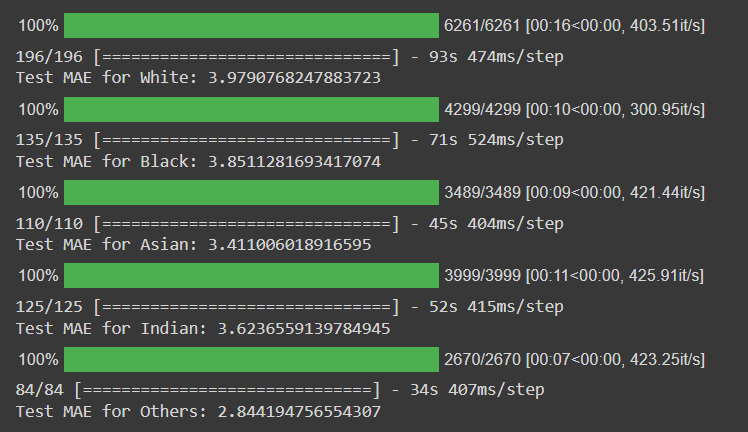

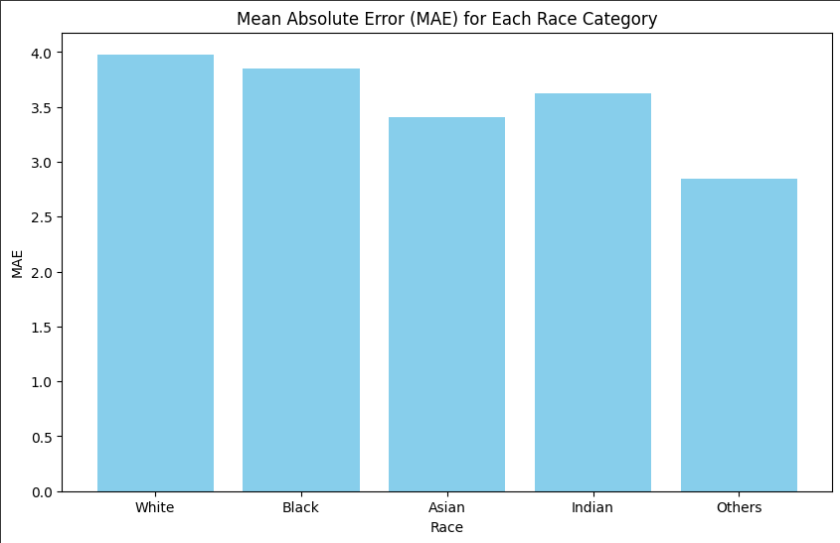

The model's performance is evaluated on each racial subset, and the following MAE values are obtained:

White: MAE = 3.98
Black: MAE = 3.85
Asian: MAE = 3.41
Indian: MAE = 3.62
Others: MAE = 2.84
The lower MAE values indicate better accuracy in age predictions.

### 6. Conclusion
The case study demonstrates the model's ability to predict ages across different racial categories. While the model performs reasonably well for all races, variations in MAE values suggest that there may be differences in prediction accuracy among racial groups. Further investigation and analysis are required to understand the factors contributing to these variations.

### 7. Future Work
Future work should focus on:

Exploring the dataset for potential biases and imbalances.
Investigating feature importance and model interpretability.
Enhancing the model's performance through fine-tuning or additional training on diverse datasets.

# Case Study 2: Age Prediction Model Evaluation of a Race with respect to other Races 

In [ ]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_absolute_error

# Load the model
model = load_model("model_v8.h5")

# Assuming 'race' column exists in your DataFrame
race_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Create subsets based on race
for race_code, race_label in race_labels.items():
    race_subset = df[df['race'] == race_code]

    if len(race_subset) == 0:
        print(f"No samples for {race_label}")
        continue

    # Extract features and normalize
    X_race = extract_features(race_subset['image'])
    X_race = X_race / 255.0

    # Extract labels
    y_age_race = np.array(race_subset['age'])

    # Make predictions
    predictions_race = model.predict(X_race)

    # Convert predictions to integer
    predicted_age_int_race = np.round(predictions_race).astype(int)

    # Calculate Mean Absolute Error for the race subset
    race_mae = mean_absolute_error(y_age_race, predicted_age_int_race)

    # Compare with other races
    other_races = df[df['race'] != race_code]
    X_other_races = extract_features(other_races['image']) / 255.0
    y_age_other_races = np.array(other_races['age'])
    predictions_other_races = model.predict(X_other_races)
    predicted_age_int_other_races = np.round(predictions_other_races).astype(int)
    other_races_mae = mean_absolute_error(y_age_other_races, predicted_age_int_other_races)

    print(f'Test MAE for {race_label} compared to other races: {other_races_mae}')

### Results
MAE for White compared to all other races: 3.50
MAE for Black compared to all other races: 3.59
MAE for Asian compared to all other races: 3.69
MAE for Indian compared to all other races: 3.65
MAE for Others compared to all other races: 3.76